<a href="https://colab.research.google.com/github/agu3ro/Pytorch-DL/blob/main/CNN_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import torch
%matplotlib inline
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [4]:
train_data = datasets.CIFAR10(root='/cnn_data', download=True, train=True, transform=transforms.Compose([transforms.RandomHorizontalFlip(), transforms.RandomCrop(size=32, padding=2), transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]))
test_data = datasets.CIFAR10(root='/cnn_data', download=True, train=False, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]))

100%|██████████| 170M/170M [00:01<00:00, 88.2MB/s]


Extracting /cnn_data/cifar-10-python.tar.gz to /cnn_data
Files already downloaded and verified


In [5]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, num_workers=0)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False, num_workers=0)

In [7]:
class Model(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = torch.nn.Conv2d(3,32,3,1)
    self.bn1 = torch.nn.BatchNorm2d(32)
    self.conv2 = torch.nn.Conv2d(32,64,3,1)
    self.bn2 = torch.nn.BatchNorm2d(64)
    self.fc1 = torch.nn.Linear(64*6*6, 256)
    self.fc2 = torch.nn.Linear(256,128)
    self.fc3 = torch.nn.Linear(128,10)
    self.dropout = torch.nn.Dropout(p=0.5)

  def forward(self,x):
    x = torch.nn.functional.relu(self.conv1(x))
    x = self.bn1(x)
    x = torch.nn.functional.max_pool2d(x,2,2)
    x = torch.nn.functional.relu(self.conv2(x))
    x = self.bn2(x)
    x = torch.nn.functional.max_pool2d(x,2,2)
    x = x.view(-1,64*6*6)
    x = torch.nn.functional.relu(self.fc1(x))
    x = torch.nn.functional.relu(self.fc2(x))
    x = self.fc3(x)
    return torch.nn.functional.log_softmax(x, dim=1)

In [8]:
model = Model()

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005, weight_decay=0.000005)
criterion = torch.nn.CrossEntropyLoss()

In [16]:
train_losses = []
train_corr = []
for i in range(5):
  trn_corr = 0
  for b, (X_train, y_train) in enumerate(train_loader):
    b+=1
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    predicted = torch.max(y_pred.data, 1)[1]
    batch_corr = (predicted == y_train).sum()
    trn_corr+=batch_corr

    if b%600==0:
      print(f"Epoch: {i}, batch: {b}, loss:{loss}")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  train_losses.append(loss)
  train_corr.append(trn_corr)

Epoch: 0, batch: 600, loss:0.42011940479278564
Epoch: 0, batch: 1200, loss:0.6090418696403503
Epoch: 0, batch: 1800, loss:0.5501678586006165
Epoch: 0, batch: 2400, loss:0.5010464191436768
Epoch: 0, batch: 3000, loss:0.2848893404006958
Epoch: 1, batch: 600, loss:0.6785656213760376
Epoch: 1, batch: 1200, loss:0.30921033024787903
Epoch: 1, batch: 1800, loss:0.4714004099369049
Epoch: 1, batch: 2400, loss:0.18654118478298187
Epoch: 1, batch: 3000, loss:0.38463208079338074
Epoch: 2, batch: 600, loss:0.35304489731788635
Epoch: 2, batch: 1200, loss:0.09289393573999405
Epoch: 2, batch: 1800, loss:0.08686241507530212
Epoch: 2, batch: 2400, loss:0.4106784164905548
Epoch: 2, batch: 3000, loss:0.21843527257442474
Epoch: 3, batch: 600, loss:0.2616579532623291
Epoch: 3, batch: 1200, loss:0.09807386249303818
Epoch: 3, batch: 1800, loss:0.2874792516231537
Epoch: 3, batch: 2400, loss:0.7201911807060242
Epoch: 3, batch: 3000, loss:0.29876384139060974
Epoch: 4, batch: 600, loss:0.10857052356004715
Epoch: 

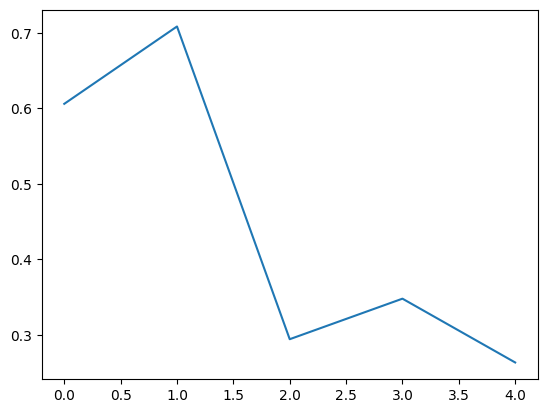

In [17]:
plt.plot([t.item() for t in train_losses], label='train_losses')

In [18]:
train_corr

[tensor(43786), tensor(43832), tensor(44052), tensor(44089), tensor(44235)]

In [19]:
(train_corr[4]/50000).item()


0.8847000002861023

In [20]:
test_corr = 0
test_losses = []
with torch.no_grad():
  for b, (X_test, y_test) in enumerate(test_loader):
    y_val = model(X_test)
    loss = criterion(y_val, y_test)
    predicted = torch.max(y_pred.data, 1)[1]
    batch_corr = (predicted == y_train).sum()
    test_corr+=batch_corr
    if b%600==0:
      print(f"batch: {b}, loss:{loss}")
    test_losses.append(loss)

  print(f"Test accuracy: {test_corr/10000}")

batch: 0, loss:0.11405224353075027
batch: 600, loss:0.6920161843299866
Test accuracy: 0.875
